## Bezier Curve

##### A Parametric curve (which means that all the coordinates of the curve depend on the independent variables t, between 0 and 1)
- 2 points -> linear curve
- 3 points -> quadratic curve
- ...

$ B(t) = \sum_{i=0}^{n}{C_{i}^{n} \cdot (1-n)^{(n-i)} \cdot t^i \cdot P_i} $

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

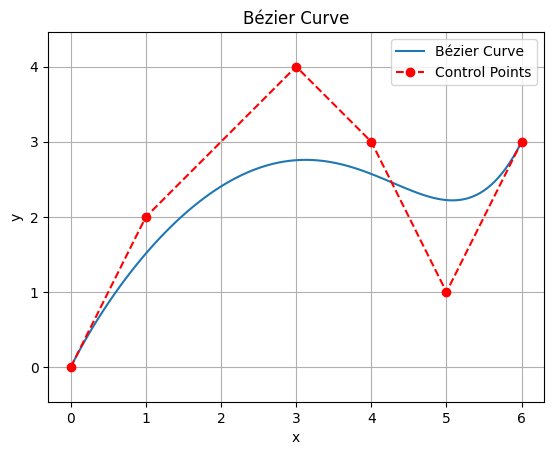

In [3]:
def bezier_curve(t, cpoints):
    degree = len(cpoints) -1 
    B = np.array([0,0])
    for i in range(0,degree+1):
        B = np.add(B, (math.comb(degree,i)*((1-t)**(degree-i))*(t**i)*cpoints[i]))
    return B

# Control points
P0 = np.array([0, 0])  
P1 = np.array([1, 2])  
P2 = np.array([3, 4])  
P3 = np.array([4, 3]) 
P4 = np.array([5, 1])
P5 = np.array([6, 3])
cpoints = [P0,P1,P2,P3,P4,P5]

n_points = 100
t_values = np.linspace(0, 1, n_points)

curve_points = np.array([bezier_curve(t, cpoints) for t in t_values])

plt.plot(curve_points[:, 0], curve_points[:, 1], label='Bézier Curve')
control_points = np.array(cpoints)
plt.plot(control_points[:, 0], control_points[:, 1], 'ro--', label='Control Points')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Bézier Curve')
plt.grid(True)
plt.axis('equal')
plt.show()


## From Bazier Curve to B-splines

If you have a lot of points (n), you need a Bezier curve with a degree of (n-1) to approximate well, but it can be quite complicated 
-> Stitch together many Bezier Curve that interpolates all of them

A k-degree B-spline Curve that is defined by n control points, will consist of (n-k) Bezier Curve

### Basis Functions

In [25]:
import torch

def basis_function(t, grid, k):
    """
    Compute the basis function of order k for the given control points grid over the domain x.

    Parameters:
    - t: Tensor of shape (n,), where n is the number of points in the domain.
    - grid: Tensor of shape (m,), where m is the number of control points.
    - k: Integer, the order of the basis function.

    Returns:
    - value: Tensor of shape (n, m-k-1), the evaluated basis functions over the domain x.
    """
    # Ensure grid is in the correct shape
    grid_ = grid.unsqueeze(dim=0)
    t_ = t.unsqueeze(dim=1)

    # Base case for k=0
    if k == 0:
        value = (t_ >= grid_[:, :-1]) * (t_ < grid_[:, 1:])
        return value
    
    # Recursive case for k > 0
    value_prev = basis_function(t, grid, k-1)
    value1 = (t_ - grid_[:, :-(k+1)]) / (grid_[:, 1:-k] - grid_[:, :-(k+1)]) * value_prev[:, :-1]
    value2 = (grid_[:, (k+1):] - t_) / (grid_[:, (k+1):] - grid_[:, 1:-k]) * value_prev[:, 1:]
    value = value1 + value2
    
    return value

# Define the control points and domain
grid = torch.linspace(-1, 1, steps=10)
t = torch.linspace(-1, 1, steps=1000)

# Calculate basis functions for various orders
basis_0 = basis_function(t, grid, k=0)
basis_1 = basis_function(t, grid, k=1)
basis_2 = basis_function(t, grid, k=2)
basis_3 = basis_function(t, grid, k=3)

# Check the shapes and some values
print(f"Basis functions of order 0: Shape: {basis_0.shape}, values: {basis_0[:5]}")
print(f"Basis functions of order 1: Shape: {basis_1.shape}, values: {basis_1[:5]}")
print(f"Basis functions of order 2: Shape: {basis_2.shape}, values: {basis_2[:5]}")
print(f"Basis functions of order 3: Shape: {basis_3.shape}, values: {basis_3[:5]}")


Basis functions of order 0: Shape: torch.Size([1000, 11]), values: tensor([[ True, False, False, False, False, False, False, False, False, False,
         False],
        [ True, False, False, False, False, False, False, False, False, False,
         False],
        [ True, False, False, False, False, False, False, False, False, False,
         False],
        [ True, False, False, False, False, False, False, False, False, False,
         False],
        [ True, False, False, False, False, False, False, False, False, False,
         False]])
Basis functions of order 1: Shape: torch.Size([1000, 10]), values: tensor([[0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5100, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.5300, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       

In [26]:
print(f"k=0, number of basis functions: {basis_0.shape[-1]}")
print(f"k=1, number of basis functions: {basis_1.shape[-1]}")
print(f"k=2, number of basis functions: {basis_2.shape[-1]}")
print(f"k=3, number of basis functions: {basis_3.shape[-1]}")

k=0, number of basis functions: 11
k=1, number of basis functions: 10
k=2, number of basis functions: 9
k=3, number of basis functions: 8


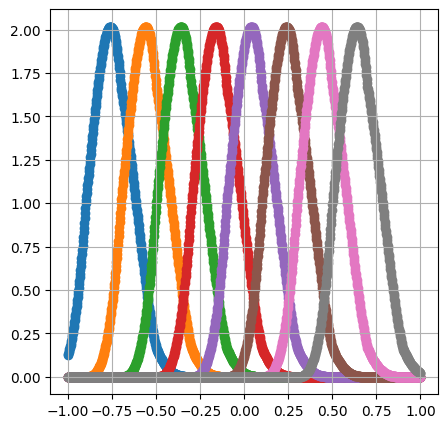

In [27]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5, 5), dpi=100)
test = torch.zeros(1000)
for i in range(basis_3.shape[-1]):
    test = torch.add(test, basis_3[:, i])
    axs.scatter(t, basis_3[:, i], marker='o')
axs.grid()